In [1]:
# Requirements
# Comment if already satisfied
#!pip install -U jupyter
#!pip install datasets transformers accelerate torch torchinfo xlrd seaborn sklearn
#!pip install --upgrade --quiet jupyter_client ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import pandas as pd

DATA_DIR = "../data/"
LM_DIR = "./out/language_model"
OUT_DIR = "./out/classification_model"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

# Load Dataset

In [3]:
#articles = pd.read_excel(os.path.join(DATA_DIR, "OpArticles_ADUs.xlsx"))
adus = pd.read_csv(os.path.join(DATA_DIR, "OpArticles_ADUs.csv")) # If pandas version doesn't support .xlsx, use this instaed

adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


Label Ratios
Value       0.483904
Fact        0.218778
Value(-)    0.173207
Value(+)    0.084274
Policy      0.039838
Name: label, dtype: float64


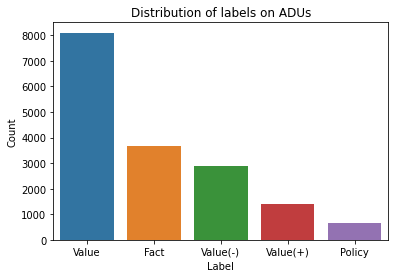

<Figure size 432x288 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Label Ratios")
print(adus["label"].value_counts() / len(adus["label"]))

fig, ax = plt.subplots()
sns.countplot(data=adus, x="label", ax=ax)
ax.set_title("Distribution of labels on ADUs")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
fig.savefig(f"{OUT_DIR}/label_distribution_full.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

Encode Labels

In [5]:
classes = ["Fact", "Policy", "Value", "Value(+)", "Value(-)"]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
adus["label"] = le.fit_transform(adus["label"])

adus.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,2
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,2
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,2
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,2
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,2


# Create Train, Validation and Test splits

Train Label Ratios
Value       0.483949
Fact        0.218738
Value(-)    0.173199
Value(+)    0.084267
Policy      0.039847
dtype: float64
Validation Label Ratios
Value       0.483763
Fact        0.218738
Value(-)    0.173199
Value(+)    0.084360
Policy      0.039940
dtype: float64
Test Label Ratios
Value       0.483871
Fact        0.218937
Value(-)    0.173238
Value(+)    0.084229
Policy      0.039725
dtype: float64


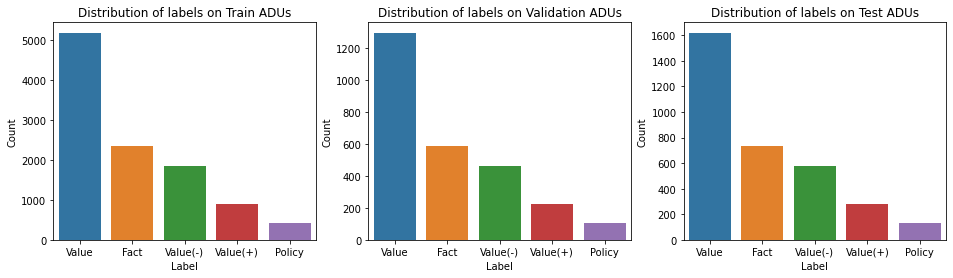

<Figure size 432x288 with 0 Axes>

In [6]:
# Maintain the ratios of labels across splits
train_val_adus = adus.groupby("label").sample(frac=0.8, random_state=SEED)
test_adus = adus.loc[adus.index.difference(train_val_adus.index)]

train_adus = train_val_adus.groupby("label").sample(frac=0.8, random_state=SEED)
val_adus = train_val_adus.loc[train_val_adus.index.difference(train_adus.index)]

fig, (train_ax, val_ax, test_ax) = plt.subplots(figsize=(16, 4), ncols=3)
for split, df, ax in zip(["Train", "Validation", "Test"], [train_adus, val_adus, test_adus], [train_ax, val_ax, test_ax]):
    df_labels = le.inverse_transform(df["label"])
    sns.countplot(x=df_labels, ax=ax, order=["Value", "Fact", "Value(-)", "Value(+)", "Policy"])
    ax.set_title(f"Distribution of labels on {split} ADUs")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    
    print(f"{split} Label Ratios")
    print(pd.Series(df_labels).value_counts() / len(df_labels))
fig.savefig(f"{OUT_DIR}/label_distribution_splits.png", dpi=150, bbox_inches='tight')
plt.show()
plt.clf()

# Convert Dataset to HF Dataset

In [7]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, DatasetInfo, Features, Value, ClassLabel
info = DatasetInfo(
    features=Features({
        "tokens": Value("string"),
        "label": ClassLabel(num_classes=len(classes), names=le.classes_.tolist()),
        "article_id": Value("string"),
        "annotator": Value("string"),
        "node": Value("int64"),
        "ranges": Value("string"),
    })
)

adus_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_adus, preserve_index=False, info=info),
    "val": Dataset.from_pandas(val_adus, preserve_index=False, info=info),
    "test": Dataset.from_pandas(test_adus, preserve_index=False, info=info)
})

print(adus_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label', 'article_id', 'annotator', 'node', 'ranges'],
        num_rows: 10716
    })
    val: Dataset({
        features: ['tokens', 'label', 'article_id', 'annotator', 'node', 'ranges'],
        num_rows: 2679
    })
    test: Dataset({
        features: ['tokens', 'label', 'article_id', 'annotator', 'node', 'ranges'],
        num_rows: 3348
    })
})


In [8]:
adus_dataset["train"].features

{'tokens': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=5, names=['Fact', 'Policy', 'Value', 'Value(+)', 'Value(-)'], id=None),
 'article_id': Value(dtype='string', id=None),
 'annotator': Value(dtype='string', id=None),
 'node': Value(dtype='int64', id=None),
 'ranges': Value(dtype='string', id=None)}

Remove unnecessary columns

In [9]:
adus_dataset = adus_dataset.remove_columns(["annotator", "node", "ranges"])
print(adus_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label', 'article_id'],
        num_rows: 10716
    })
    val: Dataset({
        features: ['tokens', 'label', 'article_id'],
        num_rows: 2679
    })
    test: Dataset({
        features: ['tokens', 'label', 'article_id'],
        num_rows: 3348
    })
})


Base Tokenizer

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)

In [11]:
def tokenize(batch):
    result = tokenizer(batch["tokens"])
    return result

In [12]:
cls_dataset = adus_dataset.map(
    tokenize, batched=True, remove_columns=["article_id", "tokens"]
)

print(cls_dataset)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10716
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2679
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3348
    })
})


# Define Dataloaders

In [13]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

BATCH_SIZE = 128 # Tested with NVIDIA Tesla T4 16GB
train_dataloader = DataLoader(
    dataset=cls_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    dataset=cls_dataset["val"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    dataset=cls_dataset["test"],
    shuffle=True,
    batch_size=1,
    collate_fn=data_collator
)

# Model Definition

In [14]:
from transformers import AutoModelForSequenceClassification
from torchinfo import summary

model = AutoModelForSequenceClassification.from_pretrained(f"{LM_DIR}/best", num_labels=len(classes))

summary(model)

Some weights of the model checkpoint at ./out/language_model/best were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./out/language_mode

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              30,509,056
│    │    └─Embedding: 3-2                              524,288
│    │    └─Embedding: 3-3                              2,048
│    │    └─LayerNorm: 3-4                              2,048
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             302,309,376
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 1,049,600
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,125
Total params:

# Define Optimizer

In [15]:
from torch import optim

optimizer = optim.AdamW(
    params=model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=1e-4,
    amsgrad=True
)

# Prepare Classification Model

In [16]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


# Define Epoch Iteration

In [20]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def epoch_iter(dataloader, model, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    losses = []

    with torch.set_grad_enabled(is_train):
        for batch in tqdm(train_dataloader):
            outputs = model(**batch)
            
            loss = output.loss

            if is_train:
                optimizer.zero_grad()
                accelerator.backward(loss)
                optimizer.step()
            
            total

            prob = F.softmax(pred, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(y.detach().cpu().numpy())
            imageIds.extend([f"road{imageId}" for imageId in ids.detach().cpu().numpy()])
            
            prob = F.softmax(outputs.logits, dim=1)
            print(prob)
            break

# Train Classification Model

In [18]:
from transformers import get_scheduler

NUM_EPOCHS = 30
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_update_steps_per_epoch * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [21]:
train_history = {
    "loss": [],
    "accuracy": []
}

val_history = {
    "loss": [],
    "accuracy": []
}

model.bert.requires_grad_(False) # Freeze language model layer

best_loss = np.inf
best_epoch = -1

print(f"Starting classification language model training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")

    epoch_iter(
        dataloader=train_dataloader,
        model=model,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )
    
    break

Starting classification language model training...
Epoch[1/30]


  0%|          | 0/84 [00:01<?, ?it/s]

tensor([[0.3159, 0.1337, 0.1355, 0.2328, 0.1821],
        [0.2787, 0.1275, 0.2687, 0.1748, 0.1503],
        [0.2577, 0.1593, 0.2558, 0.1446, 0.1826],
        [0.2388, 0.1495, 0.2421, 0.1919, 0.1777],
        [0.2609, 0.1774, 0.1967, 0.2295, 0.1355],
        [0.2165, 0.1659, 0.2175, 0.2068, 0.1934],
        [0.2647, 0.2051, 0.1739, 0.1731, 0.1832],
        [0.1673, 0.2059, 0.1591, 0.2499, 0.2179],
        [0.2280, 0.1798, 0.1302, 0.2198, 0.2422],
        [0.2162, 0.1554, 0.2259, 0.2053, 0.1973],
        [0.3305, 0.1880, 0.1718, 0.1670, 0.1428],
        [0.2365, 0.1845, 0.2732, 0.1638, 0.1419],
        [0.2331, 0.1505, 0.2550, 0.1867, 0.1747],
        [0.2402, 0.1919, 0.1718, 0.2375, 0.1586],
        [0.2560, 0.2492, 0.1869, 0.1841, 0.1237],
        [0.2660, 0.2050, 0.1828, 0.1419, 0.2043],
        [0.2208, 0.1961, 0.2254, 0.1721, 0.1856],
        [0.2366, 0.1745, 0.1979, 0.2096, 0.1815],
        [0.2191, 0.1653, 0.2078, 0.1941, 0.2136],
        [0.2179, 0.1780, 0.1626, 0.2663, 0.1751],
